## Chapter 07. MonteCarlo-TreeSearch Bandits
---
- 목표: MCTS를 이용해 gym text문제 FrozenLake, gym-chess를 해결한다

In [1]:
# Bandits 알고리즘부터

In [1]:
import pandas
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

## Bernoulli Bandit
---
베르누이 밴딧 모형

설명

- 에이전트가 행동 $A$선택에서 $K$개의 옵션이 있다고 가정(K개의 팔이 달린 슬롯머신 상상)

- 특정 행동이 보상 $r$이 1이나오는지 알 수 없음

- $K$번째 행동선택할 확률은다음과 같다. $0 \le P_{K}\le1$

- 횟수를 반복함에 따라 실패에 대한 Regret를 최소화 하기위해 아래 식을 이용

$$ \rho = T\theta^* - \sum_{t=1}^{T}r_{t}$$

여기서 $\theta^*=max_{k}\theta_k$

---

현실세계 대응 - [의료현장](https://arxiv.org/pdf/1507.08025.pdf)

1. $K$종류의 약과 $T$명의 환자들이 있음.

2. $P_{K}$ 확률로 치료한다면 어떤 약을 투여하는게 가장 좋을까요?



In [32]:
# 밴딧 모형 만들기
class BernoulliBandit():
    def __init__(self,n_actions=10):
        '''
        입력
            n_actions: 취할수 있는 행동의 개수, 기 서술한 문서의 K와 대응
        필요 속성
            Ps: 각각 행동의 선택확률
            pull: 액션을 취함
            max_reward: 최고의 행동 (theta*)
        '''
        self.Ps = np.random.random(n_actions)
        self.n_action = n_actions
    def pull(self,action):
        '''
        행동을 개시함
        입력:
            action: 행동의 인덱스, integer
        출력:
            P[action]이 수행되었는지여부, 0: 미실행, 1: 실행
        '''
        return 0 if np.any(np.random.random() > self.Ps[action]) else 1
    
    def reset(self):
        '''
        밴딧모형 리셋
        '''
    def step(self):
        '''
        밴딧모형 액션수행
        '''
    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self.Ps)

In [33]:
# 에이전트 제작
class Agents():
    def __init__(self):
        return None
    def init_actions(self,n_actions):
        '''
        행동 초기화
        입력
            n_action: 에이전트가 취할수 있는 행동수
        수행
            각 행동의 성공, 실패 횟수 -> 0
            행동을 취한 횟수 -> 0
        '''
        self.n_actions = n_actions
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._taken_actions = 0
    
    def get_action(self):
        '''
        어떤 행동을 취할것인가 -> 샘플링 방법에서 기술
        '''
        pass
    
    def update(self,action,reward):
        '''
        기록 -> 성공, 실패여부 및 행동을 취한 횟수
        입력:
            action: 몇번째 행동, integer
            reward: 성공,실패여부, float
        '''
        self._taken_actions+=1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1
    
# 랜덤 에이전트 -> 기준없이 마구 잡이로 행동하는 에이전트
class RandomAgent(Agents):
    '''
    모든 정보들은 Agents로 부터 상속
    -> get_action만 작성
    ''' 
    def get_action(self):
        '''
        임의의 행동 추출
        '''
        return np.random.choice(np.arange(self.n_actions))

## Agent1. Epsilon-greedy agent
---
$do\ while\ until\ convergence$
    
&nbsp;$for\ k=1...,K \ do$

&nbsp;&nbsp; $\theta_{k} \leftarrow {\alpha_{k}}/{(\alpha_k + \beta_k)} $

&nbsp; $end \ for$

&nbsp; 액션 $x$ 선택 $with \ \epsilon - greedy \ algorithm$ 

&nbsp; 액션 $x$ 수행 및 $r_x$ 획득

&nbsp; $(\alpha_x , \beta_x) \leftarrow (\alpha_x , \beta_x)+(r_x,1-r_x)$

$end \ do$


In [44]:
class EpsilonGreedyAgent(Agents):
    def __init__(self,epsilon=0.01):
        self.epsilon = epsilon
    
    def get_action(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self._successes/(self._successes+self._failures))
    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self.epsilon)

## Agent2. Upper Confidence Bound agent (UCB)
---
$\epsilon - greedy$는 행동선택에 특정 선호도가 부여되어있지 않음. Exploitation, Exploration의 적절 균형

$do\ while\ until\ convergence$
    
&nbsp;$for\ k=1...,K \ do$

&nbsp;&nbsp; $\theta_{k} \leftarrow {\alpha_{k}}/{(\alpha_k + \beta_k)}+\sqrt{2logN}/(\alpha_k + \beta_k) $

&nbsp;&nbsp; $where, \ N$ 현 상태 방문횟수

&nbsp; $end \ for$

&nbsp; 액션 $x$ 선택 $with\ argmax(\theta_k)$ 

&nbsp; 액션 $x$ 수행 및 $r_x$ 획득

&nbsp; $(\alpha_x , \beta_x) \leftarrow (\alpha_x , \beta_x)+(r_x,1-r_x)$

$end \ do$

In [45]:
class UCBAgent(Agents):
    def get_action(self):
        Q = self._successes/(self._successes + self._failures)
        UCB = np.sqrt(2*np.log10(self._taken_actions)/(self._successes+self._failures))
        return np.argmax(Q+UCB)
    @property
    def name(self):
        return self.__class__.__name__ 

## Agent3. Thompson sampling agent
---
보상의 분포를 안다면? - [Thompson sampling](https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf)

$do\ while\ until\ convergence$
    
&nbsp;$for\ k=1...,K \ do$

&nbsp;&nbsp; 샘플링 $\theta_k \sim Beta(\alpha_k,\beta_k)$

&nbsp;&nbsp; $where, \ N$ 현 상태 방문횟수

&nbsp; $end \ for$

&nbsp; 액션 $x$ 선택 $with\ argmax(\theta_k)$ 

&nbsp; 액션 $x$ 수행 및 $r_x$ 획득

&nbsp; $(\alpha_x , \beta_x) \leftarrow (\alpha_x , \beta_x)+(r_x,1-r_x)$

$end \ do$

In [49]:
class ThopsonSamplingAgent(Agents):
    def get_action(self):
        return np.argmax(np.random.beta(self._successes+1,self._failures+1))
    @property
    def name(self):
        return self.__class__.__name__ 

In [50]:
from collections import OrderedDict

def get_regret(env, agents, n_steps=5000, n_trials=50):
    scores = OrderedDict({
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    })

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.n_action)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials

    return scores

def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

/tmp/ipykernel_72638/1461326787.py:9: RuntimeWarning: invalid value encountered in true_divide
  return np.argmax(self._successes/(self._successes+self._failures))
/tmp/ipykernel_72638/2000589996.py:3: RuntimeWarning: invalid value encountered in true_divide
  Q = self._successes/(self._successes + self._failures)
/tmp/ipykernel_72638/2000589996.py:4: RuntimeWarning: divide by zero encountered in log10
  UCB = np.sqrt(2*np.log10(self._taken_actions)/(self._successes+self._failures))
/tmp/ipykernel_72638/2000589996.py:4: RuntimeWarning: invalid value encountered in sqrt
  UCB = np.sqrt(2*np.log10(self._taken_actions)/(self._successes+self._failures))
/tmp/ipykernel_72638/2000589996.py:4: RuntimeWarning: invalid value encountered in true_divide
  UCB = np.sqrt(2*np.log10(self._taken_actions)/(self._successes+self._failures))
/tmp/ipykernel_72638/2000589996.py:4: RuntimeWarning: divide by zero encountered in true_divide
  UCB = np.sqrt(2*np.log10(self._taken_actions)/(self._successes+self

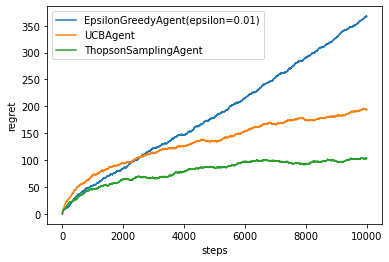

In [51]:
# Uncomment agents
agents = [
         EpsilonGreedyAgent(),
         UCBAgent(),
         ThopsonSamplingAgent()
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)